# Assignment Module 2: Product Classification

The goal of this assignment is to implement a neural network that classifies smartphone pictures of products found in grocery stores. The assignment will be divided into two parts: first, you will be asked to implement from scratch your own neural network for image classification; then, you will fine-tune a pretrained network provided by PyTorch.


## Preliminaries: the dataset

The dataset you will be using contains natural images of products taken with a smartphone camera in different grocery stores:

<p align="center">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Granny-Smith.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Pink-Lady.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Lemon.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Banana.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Vine-Tomato.jpg" width="150">
</p>
<p align="center">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Yellow-Onion.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Green-Bell-Pepper.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Arla-Standard-Milk.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Oatly-Natural-Oatghurt.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Alpro-Fresh-Soy-Milk.jpg" width="150">
</p>

The products belong to the following 43 classes:
```
0.  Apple
1.  Avocado
2.  Banana
3.  Kiwi
4.  Lemon
5.  Lime
6.  Mango
7.  Melon
8.  Nectarine
9.  Orange
10. Papaya
11. Passion-Fruit
12. Peach
13. Pear
14. Pineapple
15. Plum
16. Pomegranate
17. Red-Grapefruit
18. Satsumas
19. Juice
20. Milk
21. Oatghurt
22. Oat-Milk
23. Sour-Cream
24. Sour-Milk
25. Soyghurt
26. Soy-Milk
27. Yoghurt
28. Asparagus
29. Aubergine
30. Cabbage
31. Carrots
32. Cucumber
33. Garlic
34. Ginger
35. Leek
36. Mushroom
37. Onion
38. Pepper
39. Potato
40. Red-Beet
41. Tomato
42. Zucchini
```

The dataset is split into training (`train`), validation (`val`), and test (`test`) set.

The following code cells download the dataset and define a `torch.utils.data.Dataset` class to access it. This `Dataset` class will be the starting point of your assignment: use it in your own code and build everything else around it.

In [1]:
try:
    import google.colab
    !git clone https://github.com/marcusklasson/GroceryStoreDataset.git
except: pass

In [2]:
from pathlib import Path
from PIL import Image
from torch import Tensor
from torch.utils.data import Dataset
from typing import List, Tuple

In [7]:
class GroceryStoreDataset(Dataset):

    def __init__(self, split: str, transform=None) -> None:
        super().__init__()

        self.root = Path("GroceryStoreDataset/dataset")
        self.split = split
        self.paths, self.labels = self.read_file()

        self.transform = transform

    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, idx) -> Tuple[Tensor, int]:
        img = Image.open(self.root / self.paths[idx])
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

    def read_file(self) -> Tuple[List[str], List[int]]:
        paths = []
        labels = []

        with open(self.root / f"{self.split}.txt") as f:
            for line in f:
                # path, fine-grained class, coarse-grained class
                path, _, label = line.replace("\n", "").split(", ")
                paths.append(path), labels.append(int(label))

        return paths, labels

    def get_num_classes(self) -> int:
        return max(self.labels) + 1

## Part 1: design your own network

Your goal is to implement a convolutional neural network for image classification and train it on `GroceryStoreDataset`. You should consider yourselves satisfied once you obtain a classification accuracy on the **validation** split of **around 60%**. You are free to achieve that however you want, except for a few rules you must follow:

- You **cannot** simply instantiate an off-the-self PyTorch network. Instead, you must construct your network as a composition of existing PyTorch layers. In more concrete terms, you can use e.g. `torch.nn.Linear`, but you **cannot** use e.g. `torchvision.models.alexnet`.

- Justify every *design choice* you make. Design choices include network architecture, training hyperparameters, and, possibly, dataset preprocessing steps. You can either (i) start from the simplest convolutional network you can think of and add complexity one step at a time, while showing how each step gets you closer to the target ~60%, or (ii) start from a model that is already able to achieve the desired accuracy and show how, by removing some of its components, its performance drops (i.e. an *ablation study*). You can *show* your results/improvements however you want: training plots, console-printed values or tables, or whatever else your heart desires: the clearer, the better.

Don't be too concerned with your network performance: the ~60% is just to give you an idea of when to stop. Keep in mind that a thoroughly justified model with lower accuracy will be rewarded **more** points than a poorly experimentally validated model with higher accuracy.

### Imports

In [8]:
! python3.11 -m pip install --upgrade pip
! pip install -q wandb
! pip install -q torchmetrics
! pip install torchsummary

/Users/pelle/.zshenv:.:6: no such file or directory: /usr/local/env
DEPRECATION: Loading egg at /usr/local/lib/python3.11/site-packages/jupyter-1.0.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 5.4 MB/s eta 0:00:0000:01:00:01
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
/Users/pelle/.zshenv:.:6: no such file or directory: /usr/local/env
DEPRECATION: Loading egg at /usr/local/lib/python3.11/site-packages/jupyter-1.0.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
/Users/pelle/.zshenv:.:6: no such file or directory: /usr/local/en

### Weights and Biases for following the net

In [9]:
import wandb

WANDB_USER = "lollopelle-2-universit-di-bologna"
WANDB_PROJECT = "IPCV-assignment-2"

### Imports

In [92]:
# Standard library imports
import csv
import copy
import random
from pathlib import Path
from typing import Any, Dict
import os
import json
from datetime import datetime
import time

# Third-party library imports
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from tqdm.notebook import tqdm

# PyTorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR, LambdaLR
from torch.utils.data import DataLoader
import torch.utils
from torchmetrics.classification.accuracy import Accuracy
from torchsummary import summary

# Torchvision imports
from torchvision import transforms as T
from torchvision.models import resnet18, ResNet18_Weights

#### Functions

In [12]:
def fix_random(seed: int) -> None:
    """Fix all the possible sources of randomness.

    Args:
        seed: the seed to use.
    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

def extract_classes(csv_file_path: str) -> dict:
    """
    Extract unique pairs of IDs and labels from a CSV file.

    This function reads a CSV file, extracts the third and fourth columns,
    and creates a dictionary with unique pairs of IDs (from the fourth column)
    and labels (from the third column).

    Parameters:
    csv_file_path (str): The path to the CSV file.

    Returns:
    dict: A dictionary with IDs as keys and labels as values.
    """

    # Dictionary to store the unique pairs
    classes = {}

    # Read the CSV file
    with open(csv_file_path, mode='r', newline='', encoding='utf-8') as file:
        csv_reader = csv.reader(file)

        # Skip the CSV header
        next(csv_reader)

        for row in csv_reader:
            label = row[2]       # Third column
            id = int(row[3])     # Fourth column

            # Add the pair to the dictionary if it doesn't already exist
            if id not in classes:
                classes[id] = label

    return classes

def show_grid(dataset: GroceryStoreDataset, classes: dict) -> None:
    """Shows a grid with random images taken from the dataset.

    Args:
        dataset: the dataset containing the images.
        process: a function to apply on the images before showing them.
    """
    fig = plt.figure(figsize=(15, 5))
    indices_random = np.random.randint(10, size=10, high=len(classes.keys()))

    for count, idx in enumerate(indices_random):
        fig.add_subplot(2, 5, count + 1)
        item = dataset.__getitem__(idx) # (Tensor, idx)
        title = classes[item[1]]
        plt.title(title)
        image_processed = item[0]
        plt.imshow(T.ToPILImage()(image_processed))
        plt.axis("off")

    plt.tight_layout()
    plt.show()

def parse_compose(v):
  res = []
  for t in str(v).split("\n")[1:]:
    res.append(t.strip("    "))
  return res[:-1]

### Configuration

In [14]:
fix_random(seed=42)

device = "cpu"
if torch.cuda.is_available():
  print("All good, a GPU is available")
  device = torch.device("cuda:0")
else:
  print("Please set GPU via Edit -> Notebook Settings")

cfg = {
    "resize_size": 256,
    "crop_size": 224,
    "batch_size": 16,
    "num_epochs": 50,
    "lr": 1e-3,
    "wd": 5e-4,
    "step_size": 5
}

Please set GPU via Edit -> Notebook Settings


### Data

In [93]:
# In  order to convert integer classes into their literal
classes = extract_classes(csv_file_path = 'GroceryStoreDataset/dataset/classes.csv')

# Preprocessing
mean_image_net = [0.485, 0.456, 0.406]                              
std_image_net = [0.229, 0.224, 0.225]   
       
cfg["augment"] = True   # True/False                     
data_transforms = {
    "train": T.Compose([
                        T.RandomResizedCrop(cfg["crop_size"]),
                        T.RandomHorizontalFlip(),
                        T.RandomVerticalFlip(),                
                        T.RandomRotation(180),                              # rotation in all directions
                        T.RandomAffine(degrees=0, translate=(0.1, 0.1)),    # translations of 10%
                        T.RandomPerspective(distortion_scale=0.1, p=0.5),       
                        T.ToTensor(),
                        T.Normalize(mean_image_net, std_image_net)
                    ]),

    "val": T.Compose([
                        T.Resize(cfg["resize_size"]),               
                        T.CenterCrop(cfg["crop_size"]),             
                        T.ToTensor(),                               
                        T.Normalize(mean_image_net, std_image_net)  
                    ]),

    "test": T.Compose([
                        T.Resize(cfg["resize_size"]),               
                        T.ToTensor()                        
                    ]) # TODO: cut, it's just for debug
}

# Datasets
data_train = GroceryStoreDataset(split="train", transform=data_transforms["train"] if cfg["augment"] else None)
data_val = GroceryStoreDataset(split="val", transform=data_transforms["val"])
data_test = GroceryStoreDataset(split="test", transform=data_transforms["test"])

# DEBUG
# show_grid(dataset=data_train, classes=classes)
# show_grid(dataset=data_test, classes=classes)
# show_grid(dataset=data_val, classes=classes)

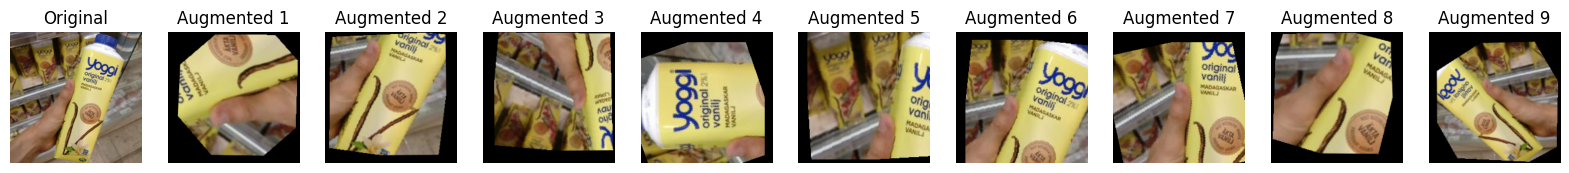

In [85]:
# TODO: delete cell, its just to visualize transformations

inv_normalize = T.Compose([
    T.Normalize(mean=[-m / s for m, s in zip(mean_image_net, std_image_net)],
                std=[1 / s for s in std_image_net])
])

# Load and prepare the image
img = Image.open("./GroceryStoreDataset/dataset/train/Packages/Yoghurt/Yoggi-Vanilla-Yoghurt/Yoggi-Vanilla-Yoghurt_020.jpg").convert("RGB")

# Apply transformations directly to the PIL image
n=9
transformed_images = [data_transforms["train"](img) for _ in range(n)]

# Convert tensors back to PIL images for visualization
# Unnormalize and convert to PIL
transformed_images_pil = [T.ToPILImage()(inv_normalize(img_tensor)) for img_tensor in transformed_images]

# Display the images
fig, axes = plt.subplots(1, n+1, figsize=(20, 5))
axes[0].imshow(img)
axes[0].set_title('Original')
axes[0].axis('off')

# for i, pil_img in enumerate(transformed_images_pil):
for i, pil_img in enumerate(transformed_images_pil):
    axes[i + 1].imshow(pil_img)
    axes[i + 1].set_title(f'Augmented {i + 1}')
    axes[i + 1].axis('off')

plt.show()

### Models

In [88]:
class Project_v1(nn.Module):
    """
    Start with the simplest NN possible
    """
    def __init__(self, n_classes):
        super(Project_v1, self).__init__()
        self.fc1 = nn.Linear(3 * 224 * 224, n_classes)  # Flatten input and map to output classes

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        x = self.fc1(x)  # Apply the fully connected layer
        return x

In [94]:
class Project_v2(nn.Module):
    """
    Add a necessary fc layer in order to distinguish the representation from their logits score
    """
    def __init__(self, n_classes):
        super(Project_v2, self).__init__()
        self.fc1 = nn.Linear(3 * 224 * 224, 1024)  
        self.fc2 = nn.Linear(1024, n_classes)       

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        x = F.relu(self.fc1(x))   # Apply ReLU activation function after first FC layer
        x = self.fc2(x)           # Apply second FC layer to get final class scores
        return x


In [105]:
class Project_v3(nn.Module):
    """
    Use CNN, so use convolutional layer 
    """
    def __init__(self, n_classes):
        super(Project_v3, self).__init__()
        # Define a single 3x3 convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        
        self.fc1 = nn.Linear(16 * 224 * 224, 1024)  # Fully Connected Layer
        self.fc2 = nn.Linear(1024, n_classes)       # Output Layer

    def forward(self, x):
        x = F.relu(self.conv1(x))  # Apply convolution and ReLU activation
        x = x.view(x.size(0), -1)  # Flatten the output for the fully connected layer
        x = F.relu(self.fc1(x))   # Apply first fully connected layer
        x = self.fc2(x)           # Apply second fully connected layer to get final class scores
        return x

In [108]:
class Project_v4(nn.Module):
    """
    Use CNN, so use convolutional layer + maxpool
    """
    def __init__(self, n_classes):
        super(Project_v4, self).__init__()
        # Define a single 3x3 convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        
        # Define a max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        self.fc1 = nn.Linear(16 * 112 * 112, 1024)  # Fully Connected Layer
        self.fc2 = nn.Linear(1024, n_classes)       # Output Layer

    def forward(self, x):
        x = F.relu(self.conv1(x))  # Apply convolution and ReLU activation
        x = self.pool(x)           # Apply max pooling
        x = x.view(x.size(0), -1)  # Flatten the output for the fully connected layer
        x = F.relu(self.fc1(x))    # Apply first fully connected layer
        x = self.fc2(x)            # Apply second fully connected layer to get final class scores
        return x

In [115]:
# TODO: explain why
class Project_v5(nn.Module):
    """
    Vanilla CNN
    """
    def __init__(self, n_classes):
        super(Project_v5, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        # FC layers
        self.fc1 = nn.Linear(64 * 56 * 56, 128) 
        self.fc2 = nn.Linear(128, n_classes)    

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  
        x = self.pool(F.relu(self.conv2(x)))  
        x = x.view(x.size(0), -1)             
        x = F.relu(self.fc1(x))               
        x = self.fc2(x)                       
        return x

In [122]:
class Project_v6(nn.Module):
    """
    Deeper CNN without residual blocks
    """
    def __init__(self, n_classes):
        super(Project_v6, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        # FC layers
        self.fc1 = nn.Linear(512 * 7 * 7, 1024) 
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, n_classes)    

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 32 x 112 x 112
        x = self.pool(F.relu(self.conv2(x)))  # 64 x 56 x 56
        x = self.pool(F.relu(self.conv3(x)))  # 128 x 28 x 28
        x = self.pool(F.relu(self.conv4(x)))  # 256 x 14 x 14
        x = self.pool(F.relu(self.conv5(x)))  # 512 x 7 x 7
        x = x.view(x.size(0), -1)             # Flatten
        x = F.relu(self.fc1(x))               
        x = F.relu(self.fc2(x))               
        x = self.fc3(x)                       
        return x

In [ ]:
# v6 + batchnorm
class Project_v7(nn.Module):
    def __init__(self, n_classes):
        super(Project_v7, self).__init__()
        
        # Convolutional layers with Batch Normalization
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        # Dropout layers
        self.dropout = nn.Dropout(p=0.5)
        
        # Fully connected layers
        self.fc1 = nn.Linear(512 * 7 * 7, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, n_classes)
    
    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # 32 x 112 x 112
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # 64 x 56 x 56
        x = self.pool(F.relu(self.bn3(self.conv3(x))))  # 128 x 28 x 28
        x = self.pool(F.relu(self.bn4(self.conv4(x))))  # 256 x 14 x 14
        x = self.pool(F.relu(self.bn5(self.conv5(x))))  # 512 x 7 x 7
        
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # Dropout
        x = F.relu(self.fc2(x))
        x = self.dropout(x)  # Dropout
        x = self.fc3(x)
        return x

In [ ]:
# try residual blocks
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        
        # First convolutional layer with Batch Normalization
        # Convolutional layer applies a 3x3 kernel. Padding=1 maintains spatial dimensions.
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)  # Batch Normalization stabilizes and accelerates training.
        self.relu = nn.ReLU(inplace=True)  # ReLU activation function for non-linearity and in-place operation to save memory.
        
        # Second convolutional layer with Batch Normalization
        # Same kernel size and padding as the first convolution to maintain spatial dimensions.
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # Shortcut connection (skip connection) to add the input to the output of convolutions
        self.shortcut = nn.Sequential()
        # If the number of channels changes or stride is not 1, adjust the shortcut path
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, padding=0),  # 1x1 convolution to match dimensions
                nn.BatchNorm2d(out_channels)  # Batch Normalization to match the output of the shortcut path
            )
    
    def forward(self, x):
        # Pass through first convolution, batch normalization, and ReLU
        out = self.relu(self.bn1(self.conv1(x)))
        # Pass through second convolution and batch normalization
        out = self.bn2(self.conv2(out))
        # Add the shortcut path to the output
        out += self.shortcut(x)
        # Apply ReLU activation function to the result of the addition
        out = self.relu(out)
        return out

class Project_v8(nn.Module):
    def __init__(self, n_classes):
        super(Project_v8, self).__init__()
        
        # Initial Convolutional Layer
        # Applies a 3x3 convolution followed by max pooling to reduce spatial dimensions and extract initial features.
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),  # Initial layer to process RGB images (3 channels)
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # Downsample spatial dimensions by a factor of 2
        )
        
        # Residual Block Layers
        # Sequential application of residual blocks to progressively extract more complex features
        # Each residual block is followed by max pooling to further reduce spatial dimensions
        self.layer2 = nn.Sequential(
            ResidualBlock(32, 64),  # Residual block with increasing number of channels
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # Downsample by another factor of 2
        )
        self.layer3 = nn.Sequential(
            ResidualBlock(64, 128),  # Further increase in channel size
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        )
        self.layer4 = nn.Sequential(
            ResidualBlock(128, 256),  # More complex features with more channels
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        )
        self.layer5 = nn.Sequential(
            ResidualBlock(256, 512),  # Final residual block with the largest number of channels
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        )
        
        # Fully Connected Layers
        # Flattened output from the convolutional layers is passed through fully connected layers for classification
        # The output of the last convolutional layer (512 channels, 7x7 spatial size) is used as input to the FC layers
        self.fc1 = nn.Linear(512 * 7 * 7, 1024)  # First fully connected layer reduces to 1024 units
        self.fc2 = nn.Linear(1024, 512)  # Second fully connected layer reduces to 512 units
        self.fc3 = nn.Linear(512, n_classes)  # Final layer outputs class scores (number of classes)
    
    def forward(self, x):
        # Pass input through each sequential layer
        x = self.layer1(x)  # Initial convolution and pooling
        x = self.layer2(x)  # Residual block and pooling
        x = self.layer3(x)  # Residual block and pooling
        x = self.layer4(x)  # Residual block and pooling
        x = self.layer5(x)  # Residual block and pooling
        # Flatten the output for the fully connected layers
        x = x.view(x.size(0), -1)  # Flattening to (batch_size, num_features)
        x = F.relu(self.fc1(x))  # First fully connected layer with ReLU activation
        x = F.relu(self.fc2(x))  # Second fully connected layer with ReLU activation
        x = self.fc3(x)  # Final fully connected layer for class scores
        return x

In [ ]:
# without BN
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        
        # First convolutional layer with ReLU activation
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.relu = nn.ReLU(inplace=True)  # ReLU activation function
        
        # Second convolutional layer with ReLU activation
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        
        # Shortcut path to add the input directly to the output
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            # If the dimensions change, adjust the shortcut path
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, padding=0)
            )
    
    def forward(self, x):
        # Pass through the first convolution and ReLU
        out = self.relu(self.conv1(x))
        # Pass through the second convolution
        out = self.conv2(out)
        # Add the shortcut path to the output
        out += self.shortcut(x)
        # Apply ReLU activation function
        out = self.relu(out)
        return out

class Project_v7(nn.Module):
    def __init__(self, n_classes):
        super(Project_v7, self).__init__()
        
        # Initial Convolutional Layer
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),  # Convolution to extract initial features
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # Pooling to reduce spatial dimensions
        )
        
        # Residual Block Layers
        self.layer2 = nn.Sequential(
            ResidualBlock(32, 64),  # Residual block with increasing channel size
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # Pooling to reduce dimensions further
        )
        self.layer3 = nn.Sequential(
            ResidualBlock(64, 128),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        )
        self.layer4 = nn.Sequential(
            ResidualBlock(128, 256),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        )
        self.layer5 = nn.Sequential(
            ResidualBlock(256, 512),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        )
        
        # Fully Connected Layers
        # Assuming the output of the last residual block is 512 channels with spatial dimensions 7x7
        self.fc1 = nn.Linear(512 * 7 * 7, 1024)  # First fully connected layer
        self.fc2 = nn.Linear(1024, 512)  # Second fully connected layer
        self.fc3 = nn.Linear(512, n_classes)  # Final layer for class scores
    
    def forward(self, x):
        # Pass input through each layer
        x = self.layer1(x)  # Initial layer
        x = self.layer2(x)  # First residual block
        x = self.layer3(x)  # Second residual block
        x = self.layer4(x)  # Third residual block
        x = self.layer5(x)  # Fourth residual block
        # Flatten the output for the fully connected layers
        x = x.view(x.size(0), -1)  # Flattening to (batch_size, num_features)
        x = F.relu(self.fc1(x))  # First fully connected layer with ReLU
        x = F.relu(self.fc2(x))  # Second fully connected layer with ReLU
        x = self.fc3(x)  # Final fully connected layer for class scores
        return x


In [139]:
cfg["model"] = "v7"
match cfg["model"] :
    case "v1" : model = Project_v1(n_classes=len(classes))
    case "v2" : model = Project_v2(n_classes=len(classes))
    case "v3" : model = Project_v3(n_classes=len(classes))
    case "v4" : model = Project_v4(n_classes=len(classes))
    case "v5" : model = Project_v5(n_classes=len(classes))
    case "v6" : model = Project_v6(n_classes=len(classes))
    case "v7" : model = Project_v7(n_classes=len(classes))
    case "v8" : model = Project_v8(n_classes=len(classes))
    case "proj": model = ProjectCNN(n_classes=len(classes))
    case _ : raise NameError("Unknown model in FLAG")

# Verifies if the model is already on the device
if next(model.parameters()).device != device:
    model.to(device)

In [140]:
summary(
    model,
    input_size=(3, cfg["crop_size"], cfg["crop_size"])
)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 112, 112]             448
            Conv2d-2           [-1, 32, 56, 56]           4,640
            Conv2d-3           [-1, 64, 28, 28]          18,496
         MaxPool2d-4           [-1, 64, 14, 14]               0
            Conv2d-5          [-1, 128, 14, 14]          73,856
            Conv2d-6          [-1, 256, 14, 14]         295,168
         MaxPool2d-7            [-1, 256, 7, 7]               0
            Conv2d-8            [-1, 512, 7, 7]       1,180,160
         MaxPool2d-9            [-1, 512, 3, 3]               0
           Conv2d-10           [-1, 1024, 3, 3]       4,719,616
        MaxPool2d-11           [-1, 1024, 1, 1]               0
           Conv2d-12           [-1, 2048, 1, 1]      18,876,416
           Linear-13                 [-1, 4096]       8,392,704
          Dropout-14                 [-

### Trainer

In [ ]:
# For automating batching

loader_train = DataLoader(
    data_train,
    batch_size=cfg["batch_size"],
    shuffle=True,
    pin_memory=True
)
loader_val = DataLoader(
    data_val,
    batch_size=cfg["batch_size"],
    shuffle=False
)
loader_test = DataLoader(
    data_test,
    batch_size=cfg["batch_size"],
    shuffle=False
)

In [ ]:
class Trainer:
    def __init__(self,
            model: nn.Module,
            train_loader: DataLoader,
            val_loader: DataLoader,
            test_loader: DataLoader,
            device: torch.device,
            num_classes: int
        ) -> None:
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.device = device
        self.num_classes = num_classes
        self.num_epochs = cfg["num_epochs"]

        self.model = model.to(device)
        self.optimizer = AdamW(self.model.parameters(), lr=cfg["lr"], weight_decay=cfg["wd"])
        num_steps = self.num_epochs * len(train_loader)
        if cfg["scheduled"]:
            self.scheduler = OneCycleLR(self.optimizer, cfg["lr"], total_steps=num_steps)
        else:
            self.scheduler = LambdaLR(self.optimizer, lr_lambda=lambda epoch: 1.0)

        self.step = 0
        self.best_acc = 0.0

        wandb.init(name=cfg["run_name"], entity=WANDB_USER, project=WANDB_PROJECT, config=cfg)
        self.ckpt_path = Path("ckpts")
        self.ckpt_path.mkdir(exist_ok=True)

    def logfn(self, values: Dict[str, Any]) -> None:
        wandb.log(values, step=self.step, commit=False)

    def train(self) -> None:
        self.training_time = time.time()
        for _ in tqdm(range(self.num_epochs), desc="Epoch"):
            self.model.train()

            for imgs, labels in self.train_loader:
                imgs = imgs.to(self.device)
                labels = labels.to(self.device)

                pred = self.model(imgs)
                # print(pred.shape, labels.shape)
                loss = F.cross_entropy(pred, labels)

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                self.scheduler.step()

                if self.step % 10 == 0:
                    self.logfn({"train/loss": loss.item()})
                    self.logfn({"train/lr": self.scheduler.get_last_lr()[0]})

                self.step += 1

            self.eval("train")
            self.eval("val")

        wandb.finish()
        self.training_time = time.time() - self.training_time


    # def test(self) -> None:
    #     wandb.init(name=cfg["run_name"]+"_test", entity=WANDB_USER, project=WANDB_PROJECT, config=cfg)
    #     self.eval("test")
    #     wandb.finish()

    @torch.no_grad()
    def eval(self, split: str) -> None:
        self.model.eval()

        if split == "train":
            loader = self.train_loader
        elif split == "val":
            loader = self.val_loader
        # elif split == "test":
        #     loader = self.test_loader
        else:
            raise ValueError(f"Unknown split: {split}")

        acc = Accuracy("multiclass", num_classes=self.num_classes).to(self.device)

        losses = []
        for imgs, labels in loader:
            imgs = imgs.to(self.device)
            labels = labels.to(self.device)

            pred = self.model(imgs)
            loss = F.cross_entropy(pred, labels)
            losses.append(loss.item())

            pred_softmax = F.softmax(pred, dim=-1)
            acc(pred_softmax, labels)

        loss = sum(losses) / len(losses)
        accuracy = acc.compute()

        self.logfn({f"{split}/loss": loss})
        self.logfn({f"{split}/acc": accuracy})

        if accuracy > self.best_acc and split == "val":
            self.best_acc = accuracy
            torch.save(self.model.state_dict(), self.ckpt_path / f"{wandb.run.name}.pt")
            self.best_model = copy.deepcopy(self.model)

    def save_model_params(self, cfg, data_transforms):
        model_dir = os.path.join("params", f"{cfg['model']}_model")
        os.makedirs(model_dir, exist_ok=True)

        timestamp = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")  # in order not to have duplicates
        training_time_formatted = time.strftime('%H-%M-%S', time.gmtime(self.training_time))
        file_name = f"ACC={self.best_acc:.2f}____TT={training_time_formatted}____TM={timestamp}.json"
        file_path = os.path.join(model_dir, file_name)

        combined_params = {
            "cfg": cfg,
            "data_transforms": {k: parse_compose(v) for k,v in data_transforms.items()},
            "model_structure" : parse_compose(model)
        }

        with open(file_path, 'w') as f:
            json.dump(combined_params, f, indent=4)

In [104]:
cfg["scheduled"]=False 
cfg["run_name"] = f"test: {cfg['model']}" + "_scheduledLR" if cfg["scheduled"] else ""

# Wandb key: 3f0834114b4b33656e70323616fa377c30c83542

trainer = Trainer(
    model,
    loader_train,
    loader_val,
    loader_test,
    device,
    num_classes=len(classes.keys())
)

NameError: name 'Trainer' is not defined

In [ ]:
trainer.train()

Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

train/acc,▂▂▂▁▂▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇▇█████████
train/loss,█▆▅▆▅▅▅▃▅▄▅▄▄▂▄▂▅▂▅▂▃▂▅▃▁▂▁▁▂▂▁▂▂▁▁▂▃▁▂▁
train/lr,▁▁▂▂▃▄▅▆▇▇███████▇▇▇▇▆▆▆▅▅▄▄▄▃▃▃▂▂▂▁▁▁▁▁
val/acc,▃▃▃▁▂▃▃▅▃▃▄▅▄▅▅▆▆▆▅▇▇▇▇▇▇█████
val/loss,▆▆▆█▇▇▆▃▆▇▄▄▅▃▅▃▃▄▄▂▂▁▁▁▂▁▁▁▁▁
train/acc,0.95265
train/loss,0.1709
train/lr,0.0
val/acc,0.67568
val/loss,1.21622


In [ ]:
# trainer.test()

In [ ]:
print(f"Best val acc = {trainer.best_acc:.3f}")

Best val acc = 0.699


In [ ]:
# Log results
trainer.save_model_params(cfg, data_transforms)

## Part 2: fine-tune an existing network

Your goal is to fine-tune a pretrained **ResNet-18** model on `GroceryStoreDataset`. Use the implementation provided by PyTorch, do not implement it yourselves! (i.e. exactly what you **could not** do in the first part of the assignment). Specifically, you must use the PyTorch ResNet-18 model pretrained on ImageNet-1K (V1). Divide your fine-tuning into two parts:

1. First, fine-tune the Resnet-18 with the same training hyperparameters you used for your best model in the first part of the assignment.
1. Then, tweak the training hyperparameters in order to increase the accuracy on the validation split of `GroceryStoreDataset`. Justify your choices by analyzing the training plots and/or citing sources that guided you in your decisions (papers, blog posts, YouTube videos, or whatever else you find enlightening). You should consider yourselves satisfied once you obtain a classification accuracy on the **validation** split **between 80 and 90%**.

### 1) Fine-tune the Resnet-18 with the same training hyperparameters you used for your best model in the first part of the assignment.

In [ ]:
# Pretrained ResNet-18 on ImageNet-1K (V1)
pt_resnet18 = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 171MB/s]


In [ ]:
## Freeze the pre-trained layers ##
for param in pt_resnet18.parameters():
    param.requires_grad = False

## Modify the last layer ##
pt_resnet18.fc = torch.nn.Linear(pt_resnet18.fc.in_features, len(classes.keys()))

## First train
cfg["run_name"] = "ResNet-18_pretrained_scratch-training"
## cfg["num_epochs"] = 5
trainer = Trainer(
    pt_resnet18,
    loader_train,
    loader_val,
    loader_test,
    device,
    num_classes=len(classes.keys())
)
trainer.train()

wandb: Currently logged in as: lollopelle-2 (lollopelle-2-universit-di-bologna). Use `wandb login --relogin` to force relogin


Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

train/acc,▁▂▄▅▆▇▇▇▇█████████████████████
train/loss,█▇▇▅▅▄▄▃▄▂▃▂▂▃▂▂▁▂▂▂▂▂▂▁▁▁▁▁▂▂▁▂▂▁▁▁▁▁▁▁
train/lr,▁▁▂▂▃▄▅▆▇▇███████▇▇▇▇▆▆▆▅▅▄▄▄▃▃▃▂▂▂▁▁▁▁▁
val/acc,▁▂▄▅▆▇▇▇▇▇▇▇██████████▇███████
val/loss,█▇▅▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/acc,0.95795
train/loss,0.1887
train/lr,0.0
val/acc,0.80743
val/loss,0.57449


In [ ]:
print(f"Best val acc (intermediate) = {trainer.best_acc:.3f}")

Best val acc (intermediate) = 0.834


In [ ]:
## Load the state of the best accuracy
sd = torch.load(f"ckpts/{cfg['run_name']}.pt")
pt_resnet18.load_state_dict(sd)

## Activate learning
for param in pt_resnet18.parameters():
    param.requires_grad = True

## Fine tuning
cfg["run_name"] = "ResNet-18_pretrained_fine-tuning"
cfg["lr"] *= 0.1
cfg["num_epochs"] = 10
trainer = Trainer(
    pt_resnet18,
    loader_train,
    loader_val,
    loader_test,
    device,
    num_classes=len(classes.keys())
)
trainer.train()

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

train/acc,▂▃▁▅▆▆█▇██
train/loss,▄▃▃▆▄█▂▃▂▄▄▅▃▅▃▃▁▂▂▄▄▂▄▃▄▃▃▂▂▂▇▁▁▁▁▄▂▂▁▃
train/lr,▁▁▂▂▃▄▅▆▆▇███████▇▇▇▇▆▆▆▅▅▄▄▄▃▃▃▂▂▂▁▁▁▁▁
val/acc,▃▃▅▁▅▄▅█▇█
val/loss,▆▇▅█▄▃▂▁▂▁
train/acc,0.98788
train/loss,0.04966
train/lr,0.0
val/acc,0.88851
val/loss,0.32398


In [ ]:
print(f"Best val acc (final) = {trainer.best_acc:.3f}")

Best val acc (final) = 0.895


### 2) Tweak the training hyperparameters in order to increase the accuracy on the validation split of `GroceryStoreDataset`.

In [ ]:
# You need to do the same but with different cfg
cfg_fine_tuning = {
    "resize_size": 256,
    "crop_size": 224,
    "batch_size": 16,
    "num_epochs": 30,
    "lr": 1e-3,
    "wd": 5e-4,
    "step_size": 5
}
cfg = cfg_fine_tuning

In [ ]:
## Freeze the pre-trained layers ##
for param in pt_resnet18.parameters():
    param.requires_grad = False

## Modify the last layer ##
pt_resnet18.fc = torch.nn.Linear(pt_resnet18.fc.in_features, len(classes.keys()))

# First train
cfg["run_name"] = "ResNet-18_pretrained_scratch-training_2"
# cfg["num_epochs"] = 5
trainer = Trainer(
    pt_resnet18,
    loader_train,
    loader_val,
    loader_test,
    device,
    num_classes=len(classes.keys())
)
trainer.train()
print(f"Best val acc (intermediate) = {trainer.best_acc:.3f}")

Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

train/acc,▁▄▇███████████████████████████
train/loss,█▇▆▄▂▂▁▂▂▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/lr,▁▁▂▂▃▄▅▆▇▇███████▇▇▇▇▆▆▆▅▅▄▄▄▃▃▃▂▂▂▁▁▁▁▁
val/acc,▁▃▆▇██████████▇████▇███▇██████
val/loss,█▆▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/acc,0.98939
train/loss,0.04075
train/lr,0.0
val/acc,0.87838
val/loss,0.33307


Best val acc (intermediate) = 0.902


In [ ]:
# Load the state of the best accuracy
sd = torch.load(f"ckpts/{cfg['run_name']}.pt")
pt_resnet18.load_state_dict(sd)

## Activate learning
for param in pt_resnet18.parameters():
    param.requires_grad = True

# Fine tuning
cfg["run_name"] = "ResNet-18_pretrained_fine-tuning_2"
cfg["lr"] *= 0.1
cfg["num_epochs"] = 10
trainer = Trainer(
    pt_resnet18,
    loader_train,
    loader_val,
    loader_test,
    device,
    num_classes=len(classes.keys())
)
trainer.train()
print(f"Best val acc (final) = {trainer.best_acc:.3f}")

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

train/acc,▇▃▁▂▄▆██▇▇
train/loss,▂▁▂▁▂▅▁▅▁▅▄▃▂▁▂▂█▆▁▅▁▄▁▂▁▁▆▁▂▁▁▂▅▁▁▁▂▁▁▅
train/lr,▁▁▂▂▃▄▅▆▆▇███████▇▇▇▇▆▆▆▅▅▄▄▄▃▃▃▂▂▂▁▁▁▁▁
val/acc,█▇▁▅▁▃▆▆▆▆
val/loss,▁▃█▆▆▅▂▃▃▂
train/acc,0.98977
train/loss,0.0355
train/lr,0.0
val/acc,0.86149
val/loss,0.42077


Best val acc (final) = 0.885
